In [1]:
# import zipfile
# with zipfile.ZipFile("/home/mira1/vlex_mira/acad/data_processed.zip", 'r') as zip_ref:
#     zip_ref.extractall("/home/mira1/vlex_mira/acad/")


In [3]:
import os
import sys; sys.path.insert(0, os.path.abspath("../../"))
import cv2
import numpy as np
import pandas as pdc
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import time
import copy
import timm
from prettytable import PrettyTable

import logging
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from torch.utils.tensorboard import SummaryWriter
this_path = Path().resolve()

In [4]:
binary_data = this_path.parent.parent/'data_processed/binary/'
models_path = this_path.parent.parent/'models/binary/'


In [5]:
experiment_no = 'exp2'
network_arch = 'regnet'

experiment_path = models_path/network_arch/experiment_no
experiment_path.mkdir(parents=True, exist_ok=True)

cfg = {
    'data': {
        'exp_name' : network_arch + '/' + experiment_no,
        'data_dir' : binary_data,
        'chkpt_path' : experiment_path,
        'best_model_path' : experiment_path/"best_model.pt",
        'tensorboard_path' : models_path/'tensorboard/',
        },
    'train': {
        'epochs' : 50,
        'batch_size' : 25,
        'lr' : 0.0001, # deafult:0.0001
        'momentum' : 0.9,
        'weight_decay' : 0.00005,
        'num_workers' : 2,
        'lr_step_size' : 5,
        'gamma' : 0.1,
        'sch_patience': 7,
        'sch_thresh': 0.001,
        'es_patience': 15,
        'es_delta': 0.02,
        'cuda': 'cuda:1',
        },
    'val': {
        'batch_size' : 25,
        'num_workers' : 2,
        }
}


# cfg = {
#     'data': {
#         'data_dir' : binary_data,
#         'chkpt_path' : models_path,
#         'best_model_path' : models_path + "best_model.pt",
#         'tensorboard_path' : models_path + "tensorboard/",
#         },
#     'train': {
#         'epochs' : 25,
#         'batch_size' : 20,
#         'lr' : 0.001,
#         'momentum' : 0.9,
#         'weight_decay' : 0.0005,
#         'num_workers' : 4,
#         'lr_step_size' : 7,
#         'gamma' : 0.1,
#         },
#     'val': {
#         'batch_size' : 5,
#         'num_workers' : 4,
#         }
# }

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation((0, 90), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomAutocontrast(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


datasets = {x: datasets.ImageFolder(os.path.join(cfg['data']['data_dir'], x), transform=data_transforms[x])
            for x in ['train', 'val']}
            
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

class_names = datasets['train'].classes

device = torch.device(cfg['train']['cuda'] if torch.cuda.is_available() else "cpu") # "cpu"


In [7]:
dataloaders = {
        'val': DataLoader(
            datasets['val'], batch_size=cfg['val']['batch_size'],
            num_workers=cfg['val']['num_workers'], drop_last=True),
        'train': DataLoader(
            datasets['train'], batch_size=cfg['train']['batch_size'],
            shuffle=True, num_workers=cfg['val']['num_workers'], drop_last=True)
    }

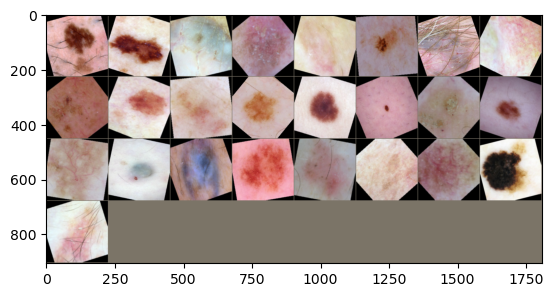

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)

### Train model

In [9]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
        
def train_model(model, criterion, optimizer, scheduler, writer, early_stopper, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    last_three_losses = []
    early_stopping_count = 0
    previous_mean_loss = 0


    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == 'val':
                scheduler.step(epoch_loss)
                # print(f"Last LR: {optimizer.param_groups[0]['lr']} --- ")

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            writer.add_scalars('acc',{f'{phase}': epoch_acc}, epoch+1)
            writer.add_scalars('loss',{f'{phase}': epoch_loss}, epoch+1)

            # save last and best checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'configuration': cfg,
                'loss': epoch_loss}, cfg['data']['chkpt_path']/f'last_checkpoint_{epoch}.pt')


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                best_metric = best_acc
                
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'metrics': best_metric,
                    'configuration': cfg
                    }, cfg['data']['best_model_path'])

        if phase == 'val':
            if early_stopper.early_stop(epoch_loss):
                print(f'Training stopped at epoch {epoch}')             
                break
                
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

### Regnet

In [10]:
model_ft = models.regnet_y_800mf(weights=models.RegNet_Y_800MF_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of gamma every lr_step_size epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
#                                         gamma=cfg['train']['gamma'])

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_ft, patience=cfg['train']['sch_patience'], 
                                                mode='min', threshold=cfg['train']['sch_thresh'], verbose=True)                                

count_parameters(model_ft)

+----------------------------------------------+------------+
|                   Modules                    | Parameters |
+----------------------------------------------+------------+
|                stem.0.weight                 |    864     |
|                stem.1.weight                 |     32     |
|                 stem.1.bias                  |     32     |
|  trunk_output.block1.block1-0.proj.0.weight  |    2048    |
|  trunk_output.block1.block1-0.proj.1.weight  |     64     |
|   trunk_output.block1.block1-0.proj.1.bias   |     64     |
|  trunk_output.block1.block1-0.f.a.0.weight   |    2048    |
|  trunk_output.block1.block1-0.f.a.1.weight   |     64     |
|   trunk_output.block1.block1-0.f.a.1.bias    |     64     |
|  trunk_output.block1.block1-0.f.b.0.weight   |    9216    |
|  trunk_output.block1.block1-0.f.b.1.weight   |     64     |
|   trunk_output.block1.block1-0.f.b.1.bias    |     64     |
| trunk_output.block1.block1-0.f.se.fc1.weight |    512     |
|  trunk

5649082

In [11]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=cfg['train']['es_patience'], min_delta=cfg['train']['es_delta'])
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/49
----------
train Loss: 0.5659 Acc: 0.7099
val Loss: 0.4972 Acc: 0.7777

Epoch 1/49
----------
train Loss: 0.4697 Acc: 0.7787
val Loss: 0.4561 Acc: 0.7914

Epoch 2/49
----------
train Loss: 0.4405 Acc: 0.7916
val Loss: 0.4359 Acc: 0.7974

Epoch 3/49
----------
train Loss: 0.4313 Acc: 0.8014
val Loss: 0.4269 Acc: 0.8074

Epoch 4/49
----------
train Loss: 0.4214 Acc: 0.8036
val Loss: 0.4277 Acc: 0.8003

Epoch 5/49
----------
train Loss: 0.4075 Acc: 0.8132
val Loss: 0.4152 Acc: 0.8116

Epoch 6/49
----------
train Loss: 0.4029 Acc: 0.8188
val Loss: 0.4239 Acc: 0.8058

Epoch 7/49
----------
train Loss: 0.3962 Acc: 0.8192
val Loss: 0.4071 Acc: 0.8132

Epoch 8/49
----------
train Loss: 0.3904 Acc: 0.8207
val Loss: 0.4170 Acc: 0.8043

Epoch 9/49
----------
train Loss: 0.3840 Acc: 0.8276
val Loss: 0.4024 Acc: 0.8151

Epoch 10/49
----------
train Loss: 0.3797 Acc: 0.8297
val Loss: 0.4062 Acc: 0.8077

Epoch 11/49
----------
train Loss: 0.3741 Acc: 0.8304
val Loss: 0.3950 Acc: 0.8143

Ep

In [15]:
def load_checkpoint(model, optimizer, filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [16]:
model_ft_new = models.regnet_y_800mf(weights=models.RegNet_Y_800MF_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_new.fc = nn.Linear(num_ftrs, 2)

model_ft_new = model_ft_new.to(device)
criterion_new = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
optimizer_ft_new = optim.SGD(model_ft_new.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

model_ft_new, optimizer_ft_new, start_epoch = load_checkpoint(model_ft_new,
                                                                optimizer_ft_new,
                                                                cfg['data']['chkpt_path']/f'last_checkpoint_49.pt')

=> loading checkpoint '/home/mira1/vlex_mira/acad/models/binary/regnet/exp2/last_checkpoint_49.pt'
=> loaded checkpoint '/home/mira1/vlex_mira/acad/models/binary/regnet/exp2/last_checkpoint_49.pt' (epoch 49)


In [17]:
experiment_no = 'exp2_1'
network_arch = 'regnet'

experiment_path = models_path/network_arch/experiment_no
experiment_path.mkdir(parents=True, exist_ok=True)

cfg = {
    'data': {
        'exp_name' : network_arch + '/' + experiment_no,
        'data_dir' : binary_data,
        'chkpt_path' : experiment_path,
        'best_model_path' : experiment_path/"best_model.pt",
        'tensorboard_path' : models_path/'tensorboard/',
        },
    'train': {
        'epochs' : 50,
        'batch_size' : 25,
        'lr' : 0.0001, # deafult:0.0001
        'momentum' : 0.9,
        'weight_decay' : 0.00005,
        'num_workers' : 2,
        'lr_step_size' : 5,
        'gamma' : 0.1,
        'sch_patience': 7,
        'sch_thresh': 0.001,
        'es_patience': 15,
        'es_delta': 0.02,
        'cuda': 'cuda:1',
        },
    'val': {
        'batch_size' : 25,
        'num_workers' : 2,
        }
}

logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=cfg['train']['es_patience'], min_delta=cfg['train']['es_delta'])
model_ft = train_model(model_ft_new, criterion_new, optimizer_ft_new, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/49
----------
train Loss: 0.2755 Acc: 0.8799
val Loss: 0.3424 Acc: 0.8404

Epoch 1/49
----------
train Loss: 0.2691 Acc: 0.8842
val Loss: 0.3344 Acc: 0.8454

Epoch 2/49
----------
train Loss: 0.2649 Acc: 0.8822
val Loss: 0.3371 Acc: 0.8480

Epoch 3/49
----------
train Loss: 0.2643 Acc: 0.8855
val Loss: 0.3344 Acc: 0.8472

Epoch 4/49
----------
train Loss: 0.2651 Acc: 0.8857
val Loss: 0.3363 Acc: 0.8501

Epoch 5/49
----------
train Loss: 0.2606 Acc: 0.8869
val Loss: 0.3373 Acc: 0.8459

Epoch 6/49
----------
train Loss: 0.2533 Acc: 0.8898
val Loss: 0.3400 Acc: 0.8464

Epoch 7/49
----------
train Loss: 0.2578 Acc: 0.8881
val Loss: 0.3310 Acc: 0.8527

Epoch 8/49
----------
train Loss: 0.2558 Acc: 0.8912
val Loss: 0.3421 Acc: 0.8419

Epoch 9/49
----------
train Loss: 0.2539 Acc: 0.8918
val Loss: 0.3270 Acc: 0.8530

Epoch 10/49
----------
train Loss: 0.2534 Acc: 0.8910
val Loss: 0.3289 Acc: 0.8556

Epoch 11/49
----------
train Loss: 0.2471 Acc: 0.8931
val Loss: 0.3274 Acc: 0.8519

Ep

### Densenet121

In [8]:
model_ft = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
num_ftrs = model_ft.classifier.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of gamma every lr_step_size epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
#                                         gamma=cfg['train']['gamma'])

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_ft, patience=cfg['train']['sch_patience'], 
                                                mode='min', threshold=cfg['train']['sch_thresh'], verbose=True)                                

count_parameters(model_ft)

+------------------------------------------------+------------+
|                    Modules                     | Parameters |
+------------------------------------------------+------------+
|             features.conv0.weight              |    9408    |
|             features.norm0.weight              |     64     |
|              features.norm0.bias               |     64     |
| features.denseblock1.denselayer1.norm1.weight  |     64     |
|  features.denseblock1.denselayer1.norm1.bias   |     64     |
| features.denseblock1.denselayer1.conv1.weight  |    8192    |
| features.denseblock1.denselayer1.norm2.weight  |    128     |
|  features.denseblock1.denselayer1.norm2.bias   |    128     |
| features.denseblock1.denselayer1.conv2.weight  |   36864    |
| features.denseblock1.denselayer2.norm1.weight  |     96     |
|  features.denseblock1.denselayer2.norm1.bias   |     96     |
| features.denseblock1.denselayer2.conv1.weight  |   12288    |
| features.denseblock1.denselayer2.norm2

6955906

In [9]:
# count = 0
# for i,param in enumerate(model_ft.parameters()):
#         if i < 200:
#                 param.requires_grad = False
#                 count+=1
# print(count)
# count_parameters(model_ft)

200
+------------------------------------------------+------------+
|                    Modules                     | Parameters |
+------------------------------------------------+------------+
| features.denseblock3.denselayer14.conv2.weight |   36864    |
| features.denseblock3.denselayer15.norm1.weight |    704     |
|  features.denseblock3.denselayer15.norm1.bias  |    704     |
| features.denseblock3.denselayer15.conv1.weight |   90112    |
| features.denseblock3.denselayer15.norm2.weight |    128     |
|  features.denseblock3.denselayer15.norm2.bias  |    128     |
| features.denseblock3.denselayer15.conv2.weight |   36864    |
| features.denseblock3.denselayer16.norm1.weight |    736     |
|  features.denseblock3.denselayer16.norm1.bias  |    736     |
| features.denseblock3.denselayer16.conv1.weight |   94208    |
| features.denseblock3.denselayer16.norm2.weight |    128     |
|  features.denseblock3.denselayer16.norm2.bias  |    128     |
| features.denseblock3.denselayer16.

4198978

In [ ]:
# # freezing some initial layers
# ct = 0
# for child in model_ft.children():
#     ct += 1
#     if ct <= 6:
#         for param in child.parameters():
#             param.requires_grad = False

# count_parameters(model_ft)

In [9]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=10, min_delta=0.01)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/59
----------
train Loss: 0.4679 Acc: 0.7828
Last LR: 1e-05 --- 
val Loss: 0.4050 Acc: 0.8132

Epoch 1/59
----------
train Loss: 0.3916 Acc: 0.8217
Last LR: 1e-05 --- 
val Loss: 0.3713 Acc: 0.8325

Epoch 2/59
----------
train Loss: 0.3656 Acc: 0.8377
Last LR: 1e-05 --- 
val Loss: 0.3599 Acc: 0.8311

Epoch 3/59
----------
train Loss: 0.3421 Acc: 0.8478
Last LR: 1e-05 --- 
val Loss: 0.3479 Acc: 0.8422

Epoch 4/59
----------
train Loss: 0.3244 Acc: 0.8578
Last LR: 1e-05 --- 
val Loss: 0.3430 Acc: 0.8443

Epoch 5/59
----------
train Loss: 0.3118 Acc: 0.8630
Last LR: 1e-05 --- 
val Loss: 0.3442 Acc: 0.8398

Epoch 6/59
----------
train Loss: 0.3039 Acc: 0.8687
Last LR: 1e-05 --- 
val Loss: 0.3298 Acc: 0.8498

Epoch 7/59
----------
train Loss: 0.2863 Acc: 0.8745
Last LR: 1e-05 --- 
val Loss: 0.3282 Acc: 0.8462

Epoch 8/59
----------
train Loss: 0.2771 Acc: 0.8788
Last LR: 1e-05 --- 
val Loss: 0.3181 Acc: 0.8496

Epoch 9/59
----------
train Loss: 0.2692 Acc: 0.8863
Last LR: 1e-05 --- 


### Resnet-18

In [8]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of gamma every lr_step_size epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
#                                         gamma=cfg['train']['gamma'])

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_ft, mode='min', threshold=0.001, verbose=True)                                

count_parameters(model_ft)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

11690538

In [9]:
# freezing some initial layers
ct = 0
for child in model_ft.children():
    ct += 1
    if ct <= 6:
        for param in child.parameters():
            param.requires_grad = False

count_parameters(model_ft)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|    layer3.0.conv1.weight     |   294912   |
|     layer3.0.bn1.weight      |    256     |
|      layer3.0.bn1.bias       |    256     |
|    layer3.0.conv2.weight     |   589824   |
|     layer3.0.bn2.weight      |    256     |
|      layer3.0.bn2.bias       |    256     |
| layer3.0.downsample.0.weight |   32768    |
| layer3.0.downsample.1.weight |    256     |
|  layer3.0.downsample.1.bias  |    256     |
|    layer3.1.conv1.weight     |   589824   |
|     layer3.1.bn1.weight      |    256     |
|      layer3.1.bn1.bias       |    256     |
|    layer3.1.conv2.weight     |   589824   |
|     layer3.1.bn2.weight      |    256     |
|      layer3.1.bn2.bias       |    256     |
|    layer4.0.conv1.weight     |  1179648   |
|     layer4.0.bn1.weight      |    512     |
|      layer4.0.bn1.bias       |    512     |
|    layer4.0.conv2.weight     |  

11007466

In [10]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=20, min_delta=0.01)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/59
----------
train Loss: 0.9174 Acc: 0.7368
Last LR: 0.0005 --- 
val Loss: 0.4123 Acc: 0.8119

Epoch 1/59
----------
train Loss: 0.3699 Acc: 0.8315
Last LR: 0.0005 --- 
val Loss: 0.3768 Acc: 0.8282

Epoch 2/59
----------
train Loss: 0.3154 Acc: 0.8596
Last LR: 0.0005 --- 
val Loss: 0.3656 Acc: 0.8343

Epoch 3/59
----------
train Loss: 0.2861 Acc: 0.8759
Last LR: 0.0005 --- 
val Loss: 0.3563 Acc: 0.8422

Epoch 4/59
----------
train Loss: 0.2503 Acc: 0.8960
Last LR: 0.0005 --- 
val Loss: 0.3549 Acc: 0.8443

Epoch 5/59
----------
train Loss: 0.2206 Acc: 0.9139
Last LR: 0.0005 --- 
val Loss: 0.3493 Acc: 0.8485

Epoch 6/59
----------
train Loss: 0.1912 Acc: 0.9247
Last LR: 0.0005 --- 
val Loss: 0.3515 Acc: 0.8488

Epoch 7/59
----------
train Loss: 0.1629 Acc: 0.9389
Last LR: 0.0005 --- 
val Loss: 0.3558 Acc: 0.8519

Epoch 8/59
----------
train Loss: 0.1362 Acc: 0.9504
Last LR: 0.0005 --- 
val Loss: 0.3663 Acc: 0.8485

Epoch 9/59
----------
train Loss: 0.1172 Acc: 0.9585
Last LR: 0.

### Resnet50

In [8]:
model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of gamma every lr_step_size epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
                                        gamma=cfg['train']['gamma'])
count_parameters(model_ft)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |    4096    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.0.conv3.weight     |   16384    |
|     layer1.0.bn3.weight      |    256     |
|      layer1.0.bn3.bias       |    256     |
| layer1.0.downsample.0.weight |   16384    |
| layer1.0.downsample.1.weight |    256     |
|  layer1.0.downsample.1.bias  |    256     |
|    layer1.1.conv1.weight     |   16384    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |  

25561130

In [ ]:
# print model's layers to have an idea of the layers

# [module for module in model_ft.modules() if not isinstance(module, nn.Sequential)]
# dict(model_ft.named_modules())
for child in model_ft.children():
    print(child)

In [9]:
# freezing some initial layers
ct = 0
for child in model_ft.children():
    ct += 1
    if ct <= 6:
        for param in child.parameters():
            param.requires_grad = False

count_parameters(model_ft)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|    layer3.0.conv1.weight     |   131072   |
|     layer3.0.bn1.weight      |    256     |
|      layer3.0.bn1.bias       |    256     |
|    layer3.0.conv2.weight     |   589824   |
|     layer3.0.bn2.weight      |    256     |
|      layer3.0.bn2.bias       |    256     |
|    layer3.0.conv3.weight     |   262144   |
|     layer3.0.bn3.weight      |    1024    |
|      layer3.0.bn3.bias       |    1024    |
| layer3.0.downsample.0.weight |   524288   |
| layer3.0.downsample.1.weight |    1024    |
|  layer3.0.downsample.1.bias  |    1024    |
|    layer3.1.conv1.weight     |   262144   |
|     layer3.1.bn1.weight      |    256     |
|      layer3.1.bn1.bias       |    256     |
|    layer3.1.conv2.weight     |   589824   |
|     layer3.1.bn2.weight      |    256     |
|      layer3.1.bn2.bias       |    256     |
|    layer3.1.conv3.weight     |  

24116202

In [10]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=5, min_delta=0.002)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/29
----------
train Loss: 1.2783 Acc: 0.6918
val Loss: 0.4474 Acc: 0.8109

Epoch 1/29
----------
train Loss: 0.4010 Acc: 0.8190
val Loss: 0.4114 Acc: 0.8190

Epoch 2/29
----------
train Loss: 0.3753 Acc: 0.8334
val Loss: 0.3980 Acc: 0.8219

Epoch 3/29
----------
train Loss: 0.3519 Acc: 0.8411
val Loss: 0.3825 Acc: 0.8293

Epoch 4/29
----------
train Loss: 0.3392 Acc: 0.8507
val Loss: 0.3736 Acc: 0.8325

Epoch 5/29
----------
train Loss: 0.3260 Acc: 0.8551
val Loss: 0.3725 Acc: 0.8317

Epoch 6/29
----------
train Loss: 0.3191 Acc: 0.8578
val Loss: 0.3748 Acc: 0.8309

Epoch 7/29
----------
train Loss: 0.3205 Acc: 0.8545
val Loss: 0.3706 Acc: 0.8319

Epoch 8/29
----------
train Loss: 0.3202 Acc: 0.8592
val Loss: 0.3703 Acc: 0.8311

Epoch 9/29
----------
train Loss: 0.3204 Acc: 0.8588
val Loss: 0.3691 Acc: 0.8306

Epoch 10/29
----------
train Loss: 0.3188 Acc: 0.8589
val Loss: 0.3695 Acc: 0.8317

Epoch 11/29
----------
train Loss: 0.3182 Acc: 0.8605
val Loss: 0.3715 Acc: 0.8319

Ep

### Inception Resnet V2

In [8]:
model_ft = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
                                        gamma=cfg['train']['gamma'])


In [9]:
logdir = cfg['data']['tensorboard_path']/'inception_resnet_v2/exp3'
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=3, min_delta=10)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/29
----------
train Loss: 0.4138 Acc: 0.8099
val Loss: 0.3909 Acc: 0.8280

Epoch 1/29
----------
train Loss: 0.3586 Acc: 0.8382
val Loss: 0.3640 Acc: 0.8375

Epoch 2/29
----------
train Loss: 0.3382 Acc: 0.8546
val Loss: 0.3527 Acc: 0.8419

Epoch 3/29
----------
train Loss: 0.3220 Acc: 0.8564
val Loss: 0.4213 Acc: 0.8159

Epoch 4/29
----------
train Loss: 0.3087 Acc: 0.8627
val Loss: 0.3348 Acc: 0.8459

Epoch 5/29
----------
train Loss: 0.2545 Acc: 0.8917
val Loss: 0.3107 Acc: 0.8606

Epoch 6/29
----------
train Loss: 0.2351 Acc: 0.9029
val Loss: 0.3067 Acc: 0.8654

Epoch 7/29
----------
train Loss: 0.2226 Acc: 0.9094
val Loss: 0.3036 Acc: 0.8680

Epoch 8/29
----------
train Loss: 0.2092 Acc: 0.9119
val Loss: 0.3041 Acc: 0.8714

Epoch 9/29
----------
train Loss: 0.1989 Acc: 0.9162
val Loss: 0.3052 Acc: 0.8688

Epoch 10/29
----------
train Loss: 0.1850 Acc: 0.9227
val Loss: 0.3046 Acc: 0.8746

Epoch 11/29
----------
train Loss: 0.1797 Acc: 0.9267
val Loss: 0.3067 Acc: 0.8730

Ep